# Otimização de Rotas Médicas (VRP com Algoritmo Genético)
Este notebook demonstra, de forma **fiel ao código do projeto**, a execução do Algoritmo Genético para otimização de rotas médicas (VRP) com **população semeada** a partir das rotas reais.

O fluxo geral é:
1. Garantir o ambiente (conda env `fiap_tsp`).
2. Executar o _script_ gerador de dados (`gerar_csv_entregas_rotas_iniciais.py`) – opcional se os CSVs já estiverem gerados.
3. Carregar `veiculos.csv`, `entregas.csv` e `rotas_iniciais.csv`.
4. Executar o GA VRP (`executar_ga_vrp`).
5. Analisar o histórico de fitness.
6. Explorar as rotas resultantes e gerar o mapa com o Folium.


## 1. Imports e configuração geral

In [1]:
import sys
import os
from pathlib import Path

PROJECT_ROOT = Path("C:\\Users\\aribe\\Documents\\FIAP\\Fase2\\otimization")
os.chdir(PROJECT_ROOT)

APP_BACKEND = "C:\\Users\\aribe\\Documents\\FIAP\\Fase2\\rag-backend"
APP_BACKEND_DATA = Path(APP_BACKEND, "data")
APP_BACKEND_STATIC = Path(APP_BACKEND, "app\\static")

print('Working dir (Local):', os.getcwd())
print('Project root:', PROJECT_ROOT)

Working dir (Local): C:\Users\aribe\Documents\FIAP\Fase2\otimization
Project root: C:\Users\aribe\Documents\FIAP\Fase2\otimization


In [2]:
import math
import random
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from src.core.medical_genetic_algorithm import (
    carregar_veiculos_csv,
    carregar_entregas_csv,
    executar_ga_vrp,
    GAConfig,
)
from src.models.base_default import BASE_PADRAO
from src.models.models import Rota
from src.visualization.gerar_mapa_rotas_vrp import gerar_mapa_rotas_vrp

## 2. Regenerar `entregas.csv` e `rotas_iniciais.csv`


In [3]:
%run src/utils/gerar_csv_entregas_rotas_iniciais.py


Arquivo de entregas gerado: data/entregas.csv (total: 100 entregas)
Arquivo de rotas iniciais gerado: data/rotas_iniciais.csv (total: 100 segmentos)


## 3. Inspecionar rapidamente os dados

Nesta etapa carregamos e conferimos:
- `data/hospitais_df.csv` – 100 hospitais e unidades de saúde, com latitude/longitude completas;
- `data/veiculos.csv` – parâmetros operacionais dos veículos;
- `data/entregas.csv` – entregas geradas a partir dos hospitais.


In [4]:
# Hospitais (fonte original)
hospitais_path = PROJECT_ROOT / 'data' / 'hospitais_df.csv'
df_hospitais = pd.read_csv(hospitais_path)
print('Total de hospitais:', len(df_hospitais))
df_hospitais.head()


Total de hospitais: 100


,IdHospital,Nome,Latitude,Longitude
0,1,Hospital de Base do Distrito Federal (IHBDF),-15.800672,-47.889162
1,2,Hospital Regional da Asa Norte (HRAN),-15.784717,-47.884175
2,3,Hospital Universitário de Brasília (HUB),-15.771302,-47.874363
3,4,Hospital Materno Infantil de Brasília (HMIB),-15.823818,-47.897529
4,5,Hospital Regional de Taguatinga (HRT),-15.822672,-48.069140


In [5]:
# Veículos
veiculos_path = PROJECT_ROOT / 'data' / 'veiculos.csv'
df_veiculos = pd.read_csv(veiculos_path)
print('Total de veículos:', len(df_veiculos))
df_veiculos.head()


Total de veículos: 10


,id_veiculo,capacidade_kg,autonomia_km,velocidade_media_kmh,custo_por_km
0,V1,1000,250,50,3.0
1,V2,850,400,60,2.5
2,V3,900,350,55,2.7
3,V4,450,550,65,2.0
4,V5,500,500,80,2.2


In [6]:
# Entregas geradas a partir dos hospitais
entregas_path = PROJECT_ROOT / 'data' / 'entregas.csv'
df_entregas = pd.read_csv(entregas_path)
print('Total de entregas:', len(df_entregas))
df_entregas.head()


Total de entregas: 100


,id,id_hospital,nome,lat,lng,prioridade,peso_kg,penalidade,tempo_estimado_entrega_min
0,1,1,Hospital de Base do Distrito Federal (IHBDF),-15.800672,-47.889162,MEDIA,31.95,2.0,10
1,2,2,Hospital Regional da Asa Norte (HRAN),-15.784717,-47.884175,MEDIA,34.19,2.0,10
2,3,3,Hospital Universitário de Brasília (HUB),-15.771302,-47.874363,MEDIA,88.62,2.0,30
3,4,4,Hospital Materno Infantil de Brasília (HMIB),-15.823818,-47.897529,ALTA,40.74,5.0,15
4,5,5,Hospital Regional de Taguatinga (HRT),-15.822672,-48.069140,CRITICA,94.66,10.0,45


## 4. Otimizar Rotas

In [7]:
from src.models.models import Entrega, Veiculo

base = BASE_PADRAO
entregas: list[Entrega] = carregar_entregas_csv(str(entregas_path))
veiculos: list[Veiculo] = carregar_veiculos_csv(str(veiculos_path))

print('Base logística:', base)
print('Qtde entregas:', len(entregas))
print('Qtde veículos:', len(veiculos))


Base logística: Base(nome='Almoxarifado Central da Secretaria de Saúde do DF', localizacao=(-15.8140447, -47.9659546))
Qtde entregas: 100
Qtde veículos: 10


### Configuração do Algoritmo Genético

A configuração abaixo reflete os parâmetros utilizados nos experimentos principais:

- `tamanho_populacao = 150`
- `geracoes = 1000`
- `taxa_mutacao = 0.25`
- `elitismo = 0.03`


In [8]:
config = GAConfig(
    tamanho_populacao=150,
    geracoes=1000,
    taxa_mutacao=0.25,
    elitismo=0.03,
)
config


GAConfig(tamanho_populacao=150, geracoes=1000, taxa_mutacao=0.25, elitismo=0.03)

### Execução do GA VRP com população semeada

Aqui chamamos `executar_ga_vrp`, que:
- constrói a população inicial **semeada** a partir de `data/rotas_iniciais.csv`;
- evolui essa população ao longo das gerações;
- retorna as melhores rotas finais e o histórico do melhor fitness por geração.


In [9]:
rotas_resultado, historico_fitness = executar_ga_vrp(
    entregas=entregas,
    veiculos=veiculos,
    base=base,
    config=config,
    caminho_rotas_iniciais=str(PROJECT_ROOT / 'data' / 'rotas_iniciais.csv'),
)

In [10]:
# ============================
# CSV – Detalhe das rotas (rota × entrega)
# ============================

dados_detalhados = []

for rota in rotas_resultado:
    veiculo_id = rota.veiculo.id_veiculo

    for ordem, entrega in enumerate(rota.entregas, start=1):
        dados_detalhados.append({
            'veiculo_id': veiculo_id,
            'ordem_na_rota': ordem,
            'entrega_id': entrega.id_entrega,
            'hospital_id': entrega.id_hospital,
            'hospital_nome': entrega.nome,
            'prioridade': entrega.prioridade.name,
            'peso_kg': entrega.peso_kg,
            'tempo_entrega_min': entrega.tempo_estimado_entrega_min,
            'lat': entrega.localizacao[0],
            'lng': entrega.localizacao[1],
        })

df_rotas_detalhado = pd.DataFrame(dados_detalhados)

csv_detalhe_path = PROJECT_ROOT / 'data' / 'resultados' / 'rotas_otimizadas.csv'
df_rotas_detalhado.to_csv(csv_detalhe_path, index=False)

#Exportar para o backend RAG
path_rag_backend = (APP_BACKEND_DATA / 'rotas_otimizadas.csv')
df_rotas_detalhado.to_csv(path_rag_backend, index=False)

print(f"CSV detalhado exportado para: {csv_detalhe_path}")
df_rotas_detalhado.head()


CSV detalhado exportado para: C:\Users\aribe\Documents\FIAP\Fase2\otimization\data\resultados\rotas_otimizadas.csv


,veiculo_id,ordem_na_rota,entrega_id,hospital_id,hospital_nome,prioridade,peso_kg,tempo_entrega_min,lat,lng
0,V1,1,12,12,Hospital Regional de Brazlândia (HRBZ),MEDIA,15.15,60,-15.675277,-48.203688
1,V1,2,72,72,UBS 1 Brazlândia,ALTA,74.18,20,-15.677219,-48.197582
2,V1,3,73,73,UPA Ceilândia I,CRITICA,91.75,20,-15.808067,-48.138417
3,V1,4,74,74,UPA Ceilândia II,ALTA,67.14,30,-15.790951,-48.137690
4,V1,5,75,75,UPA Recanto das Emas,ALTA,87.90,45,-15.911785,-48.060011


In [11]:
# Encontrar geração com o melhor (menor) fitness
total_gen = len(historico_fitness)
melhor_gen_idx = min(range(len(historico_fitness)), key=lambda i: historico_fitness[i])
melhor_gen = melhor_gen_idx + 1  # ajusta para 1-based
melhor_valor = historico_fitness[melhor_gen_idx]
melhoria_absoluta = historico_fitness[0] - historico_fitness[-1]
melhoria_relativa_pct = (melhoria_absoluta / historico_fitness[0]) * 100 if historico_fitness[0] != 0 else 0.0

print(f"Total de gerações: {total_gen}")
print(f"Fitness inicial (geração 1)         : {historico_fitness[0]:.2f}")
print(f"Fitness final (geração {total_gen})        : {historico_fitness[-1]:.2f}")
print(f"Melhor fitness observado            : {melhor_valor:.2f}")
print(f"Geração do melhor fitness           : {melhor_gen}")
print(f"Melhoria absoluta (inicial - final) : {melhoria_absoluta:.2f}")
print(f"Melhoria relativa                   : {melhoria_relativa_pct:.2f}%")

Total de gerações: 1000
Fitness inicial (geração 1)         : 222644.42
Fitness final (geração 1000)        : 4642.04
Melhor fitness observado            : 4642.04
Geração do melhor fitness           : 894
Melhoria absoluta (inicial - final) : 218002.38
Melhoria relativa                   : 97.92%


### Evolução do fitness ao longo das gerações

O gráfico abaixo mostra a evolução do **melhor fitness** em cada geração. Lembrando que, neste problema, **quanto menor o fitness, melhor a solução**.


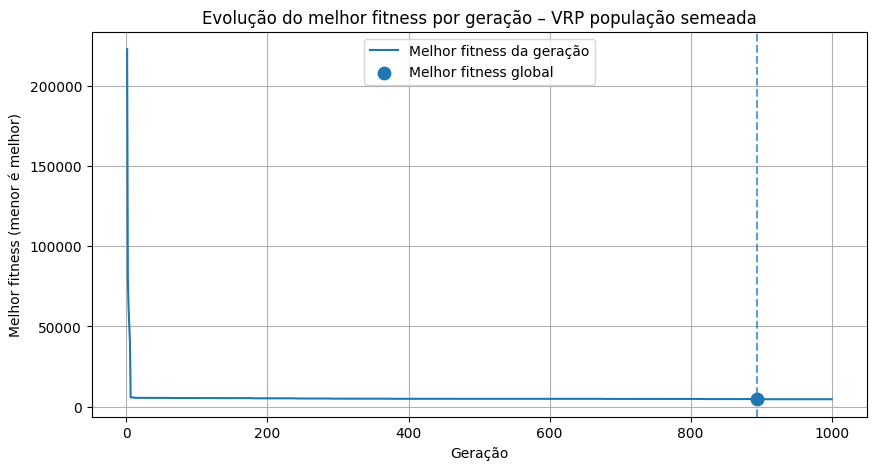

In [12]:
# Curva normal de melhor fitness por geração
geracoes = list(range(1, len(historico_fitness) + 1))

plt.figure(figsize=(10, 5))
plt.plot(geracoes, historico_fitness, label="Melhor fitness da geração")

# Marca o ponto da melhor geração global
plt.scatter([melhor_gen], [melhor_valor], s=80, marker="o", label="Melhor fitness global")

# Linha vertical na melhor geração
plt.axvline(melhor_gen, linestyle="--", alpha=0.7)

plt.xlabel("Geração")
plt.ylabel("Melhor fitness (menor é melhor)")
plt.title("Evolução do melhor fitness por geração – VRP população semeada")
plt.grid(True)
plt.legend()
plt.show()


## 5. Resultados

In [13]:
# ============================
# Rotas otimizadas – métricas
# ============================

dados_rotas_resultados = []

for rota in rotas_resultado:
    dados_rotas_resultados.append({
        'veiculo_id': rota.veiculo.id_veiculo,
        'distancia_km': rota.distancia_total_km,
        'tempo_min': rota.tempo_total_min,
        'custo_total': rota.custo_total(),
        'qtd_entregas': len(rota.entregas),
    })

df_resumo_resultados = pd.DataFrame(dados_rotas_resultados)

path_resumo_resultados = PROJECT_ROOT / 'data' / 'resumo_resultados.csv'
df_resumo_resultados.to_csv(path_resumo_resultados, index=False)

path_resumo_resultados_backend = APP_BACKEND_DATA / 'resumo_resultados.csv'
df_resumo_resultados.to_csv(path_resumo_resultados_backend, index=False)

print('Métricas das rotas otimizadas:')
print(df_resumo_resultados)

# Estatísticas gerais
print('\nEstatísticas gerais das rotas otimizadas:')
print('Distância total (km):', df_resumo_resultados['distancia_km'].sum())
print('Tempo total (min):', df_resumo_resultados['tempo_min'].sum())
print('Custo total (R$):', df_resumo_resultados['custo_total'].sum())

Métricas das rotas otimizadas:
  veiculo_id  distancia_km   tempo_min  custo_total  qtd_entregas
0         V1    115.935199  424.122238   397.805596             9
1         V2    146.149651  491.149651   406.374128            10
2         V3    114.121859  374.496573   366.129018            12
3         V4    182.770025  523.710792   404.540049            11
4         V5    171.562444  303.671833   406.437376             8
5         V6    192.233676  533.786941   515.360824            10
6         V7    102.356592  356.661736   346.598457            10
7         V8    199.683770  459.683770   556.177801             9
8         V9    186.769244  441.769244   546.276958            10
9        V10    216.323074  565.988807   696.336913            11

Estatísticas gerais das rotas otimizadas:
Distância total (km): 1627.9055318687645
Tempo total (min): 4475.04158585177
Custo total (R$): 4642.037120407282


### Geração e visualização do mapa das rotas (Folium)
Por fim, geramos o mapa HTML com as rotas VRP utilizando a função `gerar_mapa_rotas_vrp`. Cada veículo aparece em uma camada própria, permitindo ativar/desativar a visualização de forma interativa.


In [14]:
import sys
from IPython.display import display

# Caminho absoluto do arquivo de saída
mapa_path = PROJECT_ROOT / 'data' / 'resultados' / 'mapa_rotas_vrp.html'
path_rag_backend_mapa = APP_BACKEND_STATIC / 'mapa_rotas_vrp.html'
paths = [mapa_path, path_rag_backend_mapa]

# Gera o mapa e obtém o objeto folium.Map
mapa_final = gerar_mapa_rotas_vrp(
    rotas_resultado,
    lista_paths=paths,
    salvar_arquivo=True,
)

mapa_final



Mapa das rotas VRP gerado em: C:\Users\aribe\Documents\FIAP\Fase2\otimization\data\resultados\mapa_rotas_vrp.html
Mapa das rotas VRP gerado em: C:\Users\aribe\Documents\FIAP\Fase2\rag-backend\app\static\mapa_rotas_vrp.html
